In [88]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

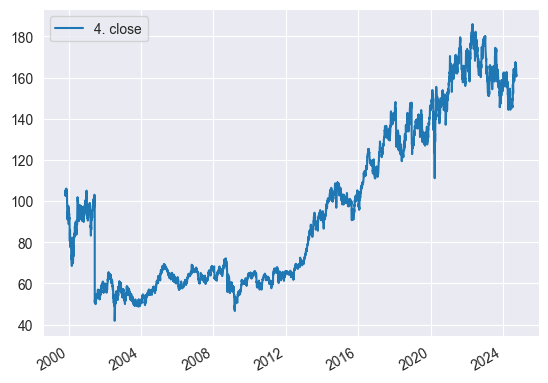

In [89]:
# Entrer le ticker code qui vous intéresse (ex.: VTRS pour Viatris, AAPL pour Apple, etc.)
symbol = str(input("Entrez le ticker code qui vous intéresse (ex.: VTRS pour Viatris, AAPL pour Apple, etc.) : ")) 

# Quelle grandeur de données on veut récupérer ('full' pour tout)
outputsize = 'full' 

# Utilisez votre propre apikey - celui la est à Roman Lakovskiy
apikey = 'N7MM7BCQTS1JEAYD' 

# Construire l'URL de la requête – méthode scientifique pour interroger l'API
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={apikey}'

# Faire la requête GET (allez, croisons les doigts !)
r = requests.get(url)
data = r.json()  # Transformer la réponse en un dictionnaire JSON

# Récupérons les données quotidiennes 
daily_data = data.get("Time Series (Daily)")
if not daily_data:
    print("Erreur : Pas de données quotidiennes. problème api?")  # Petite déception
    exit()  # On abandonne tout

# Convertissons ces chiffres mystérieux en quelque chose de compréhensible
data_df = pd.DataFrame.from_dict(daily_data, orient='index')
data_df.index = pd.to_datetime(data_df.index)  # Conversion des chaînes en dates
data_df = data_df.sort_index() # On va ordonner si jamais l'API est en désordre
data_df = data_df.apply(pd.to_numeric)  # convertissons les chiffres en vrais chiffres 
data_df.plot.line(y='4. close', use_index=True)  # une jolie courbe!

In [90]:
# Décalons la colonne '4. close' d'une ligne vers le haut pour prédire le cours de demain 
data_df["Tomorrow"] = data_df['4. close'].shift(-1)

In [91]:
data_df["Target"] = (data_df["Tomorrow"] > data_df['4. close']).astype(int)
# si aujourd'hui le cours d'action à la férmeture > à celui d'hier alors 1, sinon 0.

In [92]:
data_df = data_df.loc["2004-01-01":].copy() #20 ans d'historique c'est bien; trop ou peu d'historique pas bien

In [93]:
from sklearn.ensemble import RandomForestClassifier  # RandomForest est mieux pour stock market que régréssion linéaire (d'habitude) 🤷‍♂️

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)  # Créer un modèle

train = data_df.iloc[:-100]  # Diviser les données
test = data_df.iloc[-100:]  # Ne pas oublier le test

predictors = ['4. close', '5. volume', '1. open', '2. high', '3. low']  # faux predictors en fait
model.fit(train[predictors], train["Target"])  # Apprendre la bourse à notre modèle 🤔
data_df  # on regarde ce truc

,1. open,2. high,3. low,4. close,5. volume,Tomorrow,Target
2004-01-02,51.66,52.090,51.40,51.66,6463600,51.96,1
2004-01-05,52.00,52.080,51.50,51.96,8433800,51.73,0
2004-01-06,51.71,52.090,51.55,51.73,7298000,51.75,1
2004-01-07,51.65,51.780,51.46,51.75,7279200,51.99,1
2004-01-08,51.75,51.990,51.50,51.99,6464900,51.40,0
...,...,...,...,...,...,...,...
2024-09-23,164.40,164.500,162.72,163.22,4671645,162.78,0
2024-09-24,162.79,163.490,161.55,162.78,6041561,160.60,0
2024-09-25,163.00,163.315,160.36,160.60,5420011,161.39,1
2024-09-26,160.24,161.540,160.02,161.39,6122231,161.40,1


In [94]:
from sklearn.metrics import precision_score

# Le modèle prédit les valeurs du test.
preds = model.predict(test[predictors])

# Convertir les prédictions en série
preds = pd.Series(preds, index=test.index)

# Calculer le score de précision.
precision_score(test["Target"], preds)

np.float64(0.6226415094339622)

<Axes: >

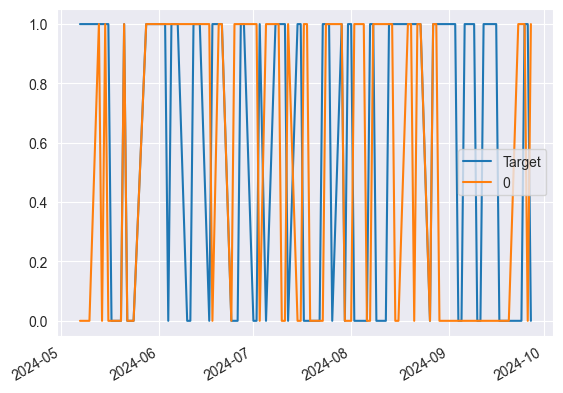

In [95]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [96]:
def predict(train, test, predictors, model): 
    # Entraînement du modèle avec les données d'apprentissage
    model.fit(train[predictors], train["Target"]) 
    # Prédictions du modèle avec les données de test
    preds = model.predict(test[predictors]) 
    # Créer une série  avec les prédictions et les dates (index) de l'ensemble de test
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [97]:
def backtest(data, model, predictors, start=500, step=125):
    all_predictions = []  # Liste pour stocker toutes les prédictions

    for i in range(start, data.shape[0], step):
        
        # Séparer l'ensemble d'apprentissage des données initiales jusqu'à l'indice courant parce que pourquoi pas 
        train = data.iloc[0:i].copy()
        
        # Séparer l'ensemble de test à partir de l'indice courant jusqu'à (indice courant + pas)
        test = data.iloc[i:(i+step)].copy()
        
        # Vérifier que les ensembles ne sont pas vides, des fois qu'on fasse des calculs sur rien
        # Générer les prédictions avec les ensembles d'apprentissage et de test
        predictions = predict(train, test, predictors, model)
        
        # Ajouter les prédictions à la liste de toutes les prédictions
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)  # Retourner la concaténation des prédictions

In [98]:
predictions = backtest(data_df, model, predictors)

In [99]:
predictions["Predictions"].value_counts()

Predictions
0    2761
1    1959
Name: count, dtype: int64

In [100]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5176110260336907)

In [101]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.511864
0    0.488136
Name: count, dtype: float64

In [102]:
# ajoutons vrai predictors - basé sur historique, marché versus il y a 2 jour, il y une semaine ect
horizons = [2,5,25,50,125]
new_predictors = []

for horizon in horizons:
    rolling_averages = data_df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data_df[ratio_column] = data_df['4. close'] / rolling_averages['4. close']
    
    trend_column = f"Trend_{horizon}"
    data_df[trend_column] = data_df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [76]:
data_df = data_df.dropna(subset=data_df.columns[data_df.columns != "Tomorrow"])

In [77]:
data_df

,1. open,2. high,3. low,4. close,5. volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_25,Trend_25,Close_Ratio_50,Trend_50,Close_Ratio_125,Trend_125
2004-07-02,55.28,56.140,55.12,55.35,4800000,54.95,0,0.998917,0.0,0.998269,2.0,0.990111,13.0,1.001636,26.0,1.033228,58.0
2004-07-06,55.17,55.430,54.92,54.95,5752600,54.53,0,0.996374,0.0,0.991126,1.0,0.983547,12.0,0.993926,26.0,1.025303,57.0
2004-07-07,54.78,54.990,54.43,54.53,5457900,54.76,1,0.996164,0.0,0.987862,0.0,0.976855,12.0,0.986026,25.0,1.017041,57.0
2004-07-08,54.62,55.540,54.60,54.76,5780100,54.99,1,1.002104,1.0,0.995419,1.0,0.981686,12.0,0.989877,25.0,1.020872,57.0
2004-07-09,54.90,55.180,54.78,54.99,3899600,54.89,0,1.002096,2.0,1.001348,2.0,0.986665,12.0,0.993808,25.0,1.024702,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,164.40,164.500,162.72,163.22,4671645,162.78,0,0.997129,0.0,0.988709,1.0,0.991727,16.0,1.012222,29.0,1.060962,72.0
2024-09-24,162.79,163.490,161.55,162.78,6041561,160.60,0,0.998650,0.0,0.991195,0.0,0.988297,15.0,1.007801,29.0,1.057716,71.0
2024-09-25,163.00,163.315,160.36,160.60,5420011,161.39,1,0.993259,0.0,0.984575,0.0,0.974957,14.0,0.993125,28.0,1.043408,70.0
2024-09-26,160.24,161.540,160.02,161.39,6122231,161.40,1,1.002453,1.0,0.993597,1.0,0.979762,14.0,0.997417,28.0,1.048366,70.0


In [78]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [103]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.5] = 1
    preds[preds <.5] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [80]:
predictions = backtest(data_df, model, new_predictors)

In [81]:
predictions["Predictions"].value_counts()

Predictions
1.0    2433
0.0    2162
Name: count, dtype: int64

In [82]:
precision_score(predictions["Target"], predictions["Predictions"])

np.float64(0.5002055076037814)

In [83]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.511643
0    0.488357
Name: count, dtype: float64

In [55]:
predictions.tail(10)

,Target,Predictions
2024-09-16,1,1.0
2024-09-17,1,1.0
2024-09-18,1,1.0
2024-09-19,0,1.0
2024-09-20,0,1.0
2024-09-23,1,1.0
2024-09-24,0,1.0
2024-09-25,1,1.0
2024-09-26,1,1.0
2024-09-27,0,1.0
